# Improving Diabetes Care Through Early Readmission Prediction Models

## Project Task
Find an exciting business problem, find data, and solve the problem with machine learning in Python using the algorithms covered in the course. You do not need to follow the CRISP-DM methodology directly, but you should articulate the following in your final products produced:

- **Business understanding** : What does the business need?
- **Data understanding** : What data do we have/need? Is it clean?
- **Data preparation** : How do we organize the data for modeling?
- **Modeling** : What modeling techniques should we apply?
- **Evaluation** : Which model best meets the business objectives?
- **Deployment** : How to get the model in production and ensure it works?

**Note**: It is required that your team use GitHub to host your code, collaborate, and manage versions. GitHub helps ensure traceability, allow rollback, and avoid unintended overwrites and loss of code. You can use the integration between Google Colab and GitHub to achieve the goals of the project if you are using Google Colab.

## **Business Case Definition**

**Business Understanding**: To reduce early (within 30-day) hospital readmissions of diabetic patients by predicting high-risk individuals, enabling targeted intervention and improved clinical care. With the goal to improve patient outcomes, reduce healthcare costs, enhance quality of care metrics, support evidence based and data-driven decisions. 


**Critical Question to be answered**: Can we use historical patient data to predict which diabetic patients are likely to be readmitted within 30 days of discharge? answering this question allows healthcare providers to implement targeted interventions for high-risk patients, allocate resources more efficiently, and develop clinical protocols that adapt based on patient risk profiles.


**Data understanding** The data is partially clean and required preprocessing steps before modeling. key data characteristics include;

- Patients: Diagnosed with diabetes, with a hospital stay between 1–14 days.

- Features are:

    - Demographics: Age, race, gender,
    - Admission Info: Admission type, discharge disposition, time in hospital.
    - Diagnoses: Primary, secondary, tertiary diagnoses (ICD-9 codes).
    - Lab Results: HbA1c test results, number of lab procedures.
    - Medication Use: 23 medication features (e.g., insulin, metformin).
    - Utilization History: Number of prior outpatient, emergency, and inpatient visits.
    - Target Variable: readmitted (with values like <30, >30, NO – indicating time till readmission).


**Data Preparation**: The cleaning steps and feature Engineering we performed includes

- Age column cleaning: Used regex to standardize/strip unwanted characters.
- Handling Missing Values: Dropped columns with more than 40% missing values. Imputed missing values in key demographic fields, e.g., **race**.
- Medication columns: Aggregated 23 individual drug features into a binary **polypharmacy_score** to simplify and capture overall drug use.
- Encoding: Used One-Hot Encoding for categorical variables.
- Scaling: Standardized numerical features using StandardScaler
- Clustering for feature importance: created **risk_cluster** to highlight the cluster with the hoghest readmission rate as a means of handling inballance and emphasizing risk class.
- Resolving Class imbalance: <30 (readmission within 30 days) is the minority class and require resampling or threshold tuning. We employed **SMOTE** technique to handle this in the modelling section


**Modeling** : We applied a combination of unsupervised learning (clustering) and supervised classification techniques, which is a strong and well-rounded approach. We applied Kmeans clustering due to the class imbalance in the readmitted variable (<30 being rare), unsupervised clustering helps uncover underlying patient risk profiles. uclustering provided clinical insight and allowed risk stratification even before supervised classification. Supervised Leanring models includes; 

- The Simple and interpretable **Logistic Regression (baseline)**
- The Robust **Random Forest** which handles non-linearities
- The High performance **XGBoost** which handles imbalance datasets well and finally,
- The **MLP Classifier** (Neural Net) best known for capturing complex patterns



**Evaluation Metrics:**

- Precision, Recall, F1-score, Support 
- Confusion Matrix
- Special focus on recall for <30 class due to the clinical importance of catching true readmissions



## **Data Cleaning** 

In [ ]:
# import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore") 

# Green aesthetic
sns.set(style="whitegrid")
green_palette = ["#A3E4D7", "#58D68D", "#27AE60"]
sns.set_palette(green_palette)

In [3]:
# Load CSV File into df variable
df= pd.read_csv('https://github.com/clappy203/AAI_510_Project/blob/main/diabetic_data.csv?raw=true')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df['age'] = df['age'].str.replace(r'[\[\)\<\>]', '', regex=True) # Remove brackets and parentheses
df.replace('?', pd.NA, inplace=True) # Replace "?" with NaN

In [8]:
df['encounter_id'].is_unique # Check if patient_nbr is unique

True

In [5]:
# Check nulls
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

weight               98569
max_glu_serum        96420
A1Cresult            84748
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
dtype: int64

In [6]:
missing_percentage = round((df.isnull().sum() / len(df)) * 100,0) # Calculate the percentage of missing values for each column
df = df.drop(columns=missing_percentage[missing_percentage >= 40].index) # Drop columns with 40% or more missing values
df.shape

(101766, 45)

In [7]:
df['race'] = df['race'].fillna('Unknown')
df_clean = df.dropna() # Drop rows with missing values in remaining columns

## **EDA**

In [8]:
# Summary of column
df_clean.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
encounter_id,100244.0,NaN,NaN,NaN,166017230.172439,102675587.497558,12522.0,85567765.5,153049401.0,231062494.5,443867222.0
patient_nbr,100244.0,NaN,NaN,NaN,54629710.760794,38694516.07545,135.0,23461035.75,46049076.0,87785298.0,189502619.0
race,100244,6,Caucasian,75079,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,100244,3,Female,53922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,100244,10,70-80,25898,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_type_id,100244.0,NaN,NaN,NaN,2.022754,1.444914,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,100244.0,NaN,NaN,NaN,3.729281,5.281027,1.0,1.0,1.0,4.0,28.0
admission_source_id,100244.0,NaN,NaN,NaN,5.760604,4.063089,1.0,1.0,7.0,7.0,25.0
time_in_hospital,100244.0,NaN,NaN,NaN,4.420275,2.991273,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,100244.0,NaN,NaN,NaN,43.173716,19.691484,1.0,32.0,44.0,57.0,132.0


### 🎂 Patient Age Distribution
Most patients fall between the 50–80 age brackets, with the highest concentration in the 70–80 range. This aligns with diabetes being more prevalent in older populations and may inform feature importance.


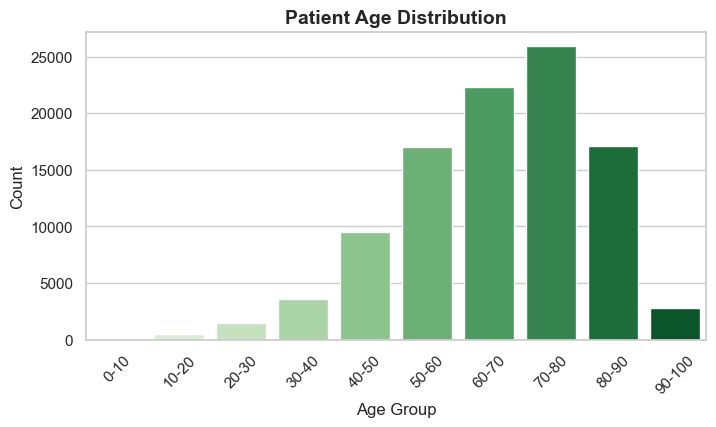

In [9]:
# Age Distribution with multiple greens
green_palette_10 = sns.color_palette("Greens", n_colors=10)

plt.figure(figsize=(8, 4))
sns.countplot(x='age', data=df_clean, order=sorted(df_clean['age'].unique()),
              palette=green_palette_10)
plt.title("Patient Age Distribution", fontsize=14, weight='bold')
plt.xticks(rotation=45)
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

### 👤 Demographics: Gender and Race
There are slightly more female than male patients. The majority of patients are Caucasian, followed by African American patients. This demographic distribution may reflect historical sampling or regional patient data.


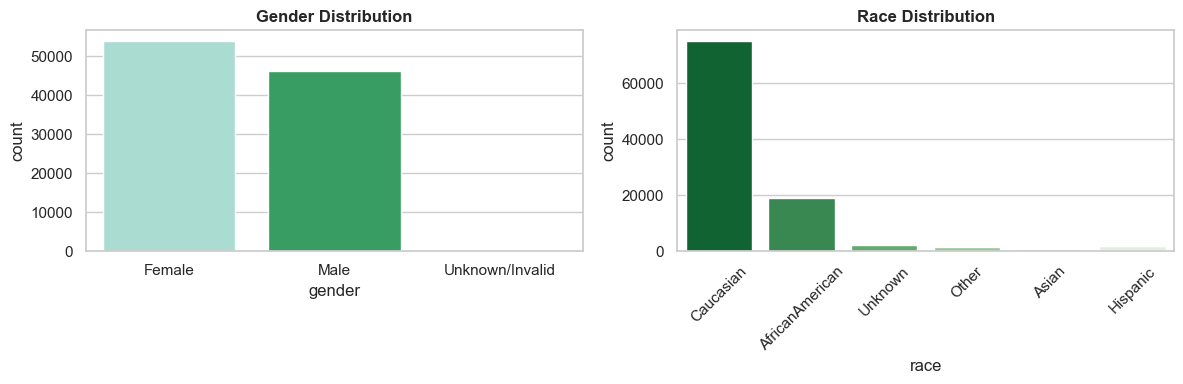

In [10]:
# Gender and Race Breakdown
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x='gender', data=df_clean, ax=axs[0],
              palette=sns.color_palette(["#A3E4D7", "#27AE60"]))
axs[0].set_title("Gender Distribution", fontsize=12, weight='bold')

sns.countplot(x='race', data=df_clean, ax=axs[1],
              palette="Greens_r")
axs[1].set_title("Race Distribution", fontsize=12, weight='bold')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 🩺 Readmission Distribution
The dataset is highly imbalanced, with the majority of patients not readmitted or readmitted after 30 days. Only a small portion were readmitted within 30 days, which may impact model performance and could require class balancing strategies.


In [11]:
# Binary classification: readmitted (1 = <30 days, 0 = No or >30 days)
df_clean['readmission_binary'] = df_clean['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df_clean = df_clean.drop(columns=['readmitted'])
df_clean['readmission_binary'].value_counts()

readmission_binary
0    88994
1    11250
Name: count, dtype: int64

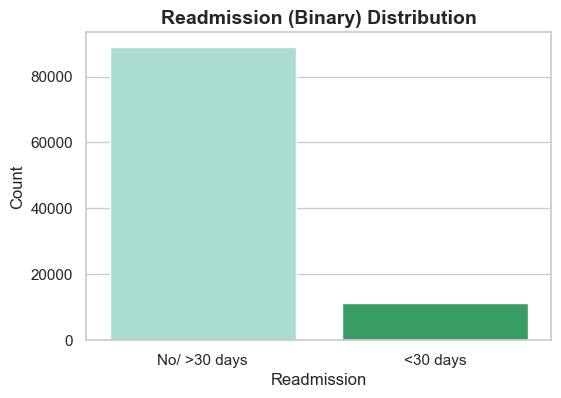

In [12]:
# Convert target to string for color mapping
df_clean['readmission_binary'] = df_clean['readmission_binary'].astype(str)

# Readmission Distribution with distinct green shades
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x='readmission_binary', data=df_clean,
              palette={'0': "#A3E4D7", '1': "#27AE60"})
plt.title("Readmission (Binary) Distribution", fontsize=14, weight='bold')
plt.xticks([0, 1], ['No/ >30 days', '<30 days'])
plt.xlabel("Readmission")
plt.ylabel("Count")
plt.show()


### 📈 Top Feature Correlations
The most positively correlated features with readmission are `number_inpatient`, `number_emergency`, and `discharge_disposition_id`. These features may indicate severity or complexity of care and are good candidates for modeling.


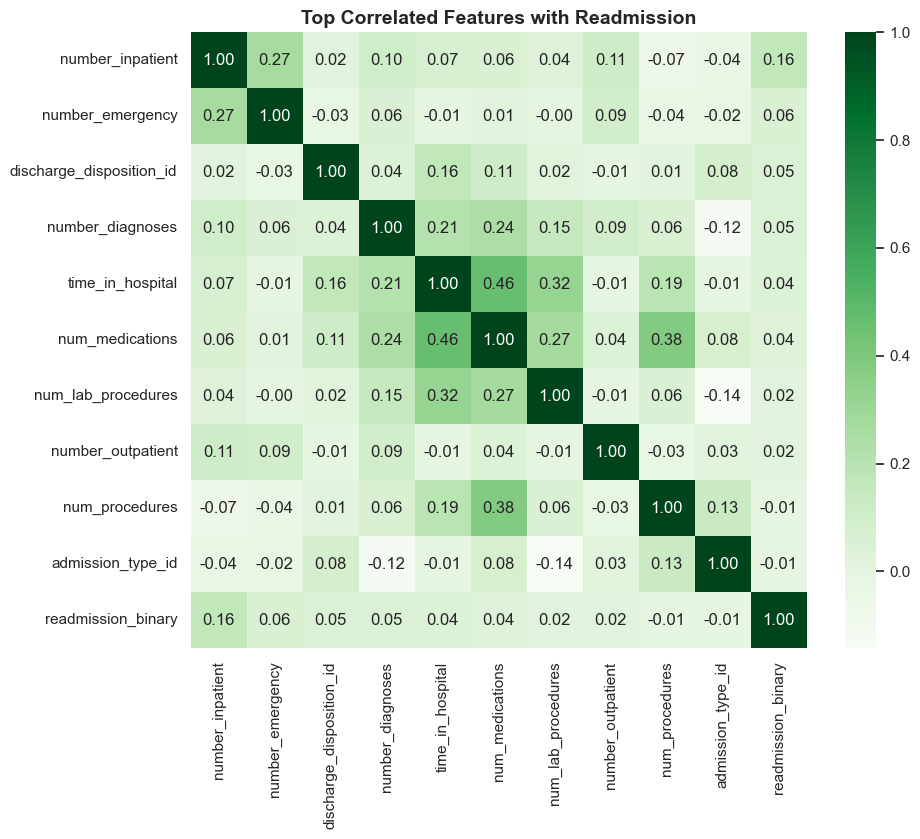

In [13]:
# Correlation Heatmap
# convet readmission_binary to numeric
df_clean['readmission_binary'] = df_clean['readmission_binary'].astype(int)

plt.figure(figsize=(10, 8))
cor_matrix = df_clean.select_dtypes(include='number').corr()
top_corr = cor_matrix['readmission_binary'].abs().sort_values(ascending=False)[1:11].index.tolist()
top_corr.append('readmission_binary')

sns.heatmap(df_clean[top_corr].corr(), annot=True, fmt=".2f", cmap="Greens", square=True)
plt.title("Top Correlated Features with Readmission", fontsize=14, weight='bold')
plt.show()


### 📊 Top Correlated Features (Bar View)
A bar plot of correlation strength provides a clear ranking of predictive power. Features like `number_inpatient` and `num_medications` show stronger associations with readmission risk.


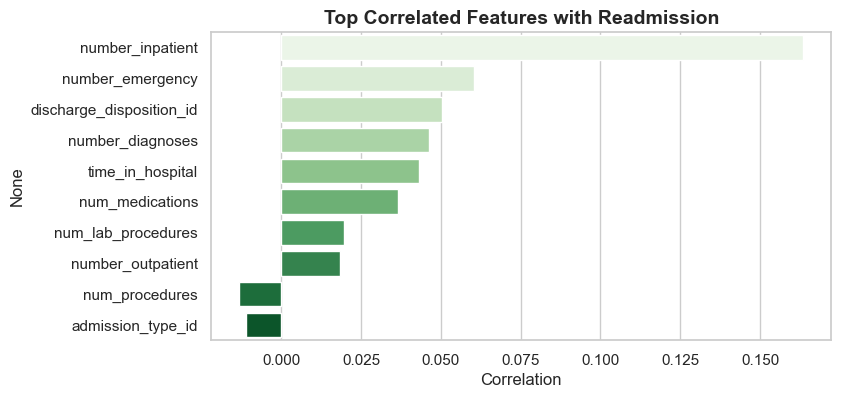

In [14]:
# Bar Plot of Correlation with Target
cor_matrix = df_clean.select_dtypes(include='number').corr()
target_corr = cor_matrix['readmission_binary'].drop('readmission_binary').sort_values(key=abs, ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=target_corr.values[:10], y=target_corr.index[:10], palette="Greens")
plt.title("Top Correlated Features with Readmission", fontsize=14, weight='bold')
plt.xlabel("Correlation")
plt.show()


### 🏥 Procedures vs Readmission
The number of procedures is similar between the readmitted and non-readmitted groups. This may suggest that procedure count alone is not a strong predictor, but could be informative when combined with other clinical variables.


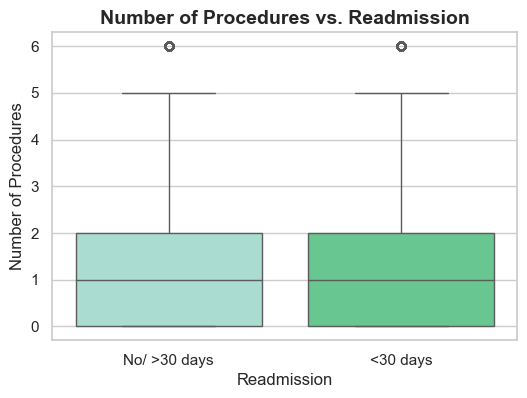

In [15]:
# Boxplot - Procedures vs Readmission
plt.figure(figsize=(6, 4))
sns.boxplot(x='readmission_binary', y='num_procedures', data=df_clean, palette=green_palette[:2])
plt.title("Number of Procedures vs. Readmission", fontsize=14, weight='bold')
plt.xticks([0, 1], ['No/ >30 days', '<30 days'])
plt.xlabel("Readmission")
plt.ylabel("Number of Procedures")
plt.show()

### ⏳ Time in Hospital vs Readmission
Patients readmitted within 30 days tend to have longer hospital stays. This suggests that length of stay could be associated with higher clinical complexity or complications.


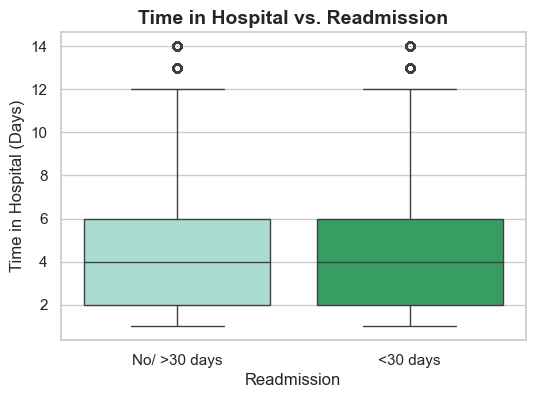

In [16]:
# Boxplot – Time in Hospital vs Readmission
plt.figure(figsize=(6, 4))
sns.boxplot(x='readmission_binary', y='time_in_hospital', data=df_clean,
            palette=['#A3E4D7', '#27AE60'])
plt.title("Time in Hospital vs. Readmission", fontsize=14, weight='bold')
plt.xticks([0, 1], ['No/ >30 days', '<30 days'])
plt.xlabel("Readmission")
plt.ylabel("Time in Hospital (Days)")
plt.show()

### 🧾 Top Primary Diagnoses
The most common diagnosis codes include circulatory and endocrine-related issues. Understanding which diagnoses are most prevalent can help tailor targeted intervention strategies.


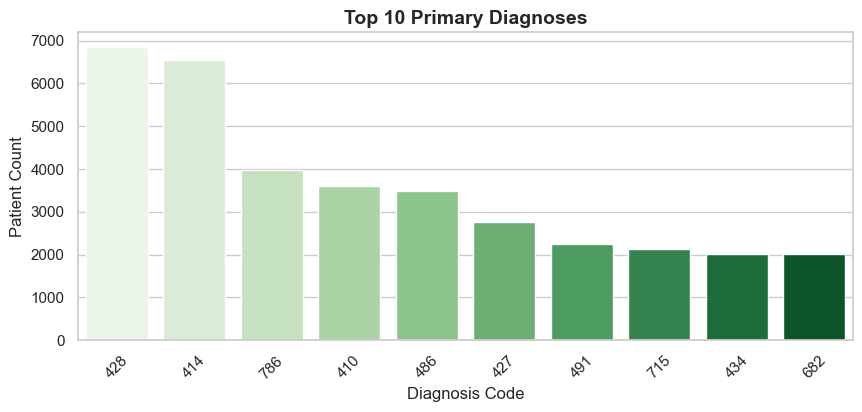

In [17]:
# Top Primary Diagnoses
plt.figure(figsize=(10, 4))
top_diag1 = df_clean['diag_1'].value_counts().head(10)
sns.barplot(x=top_diag1.index, y=top_diag1.values, palette="Greens")
plt.title("Top 10 Primary Diagnoses", fontsize=14, weight='bold')
plt.xlabel("Diagnosis Code")
plt.ylabel("Patient Count")
plt.xticks(rotation=45)
plt.show()


### 🚪 Admission Type vs Readmission
Certain admission types (e.g., emergency) have higher rates of readmission. This can inform triage protocols and support prioritization in patient follow-up planning.


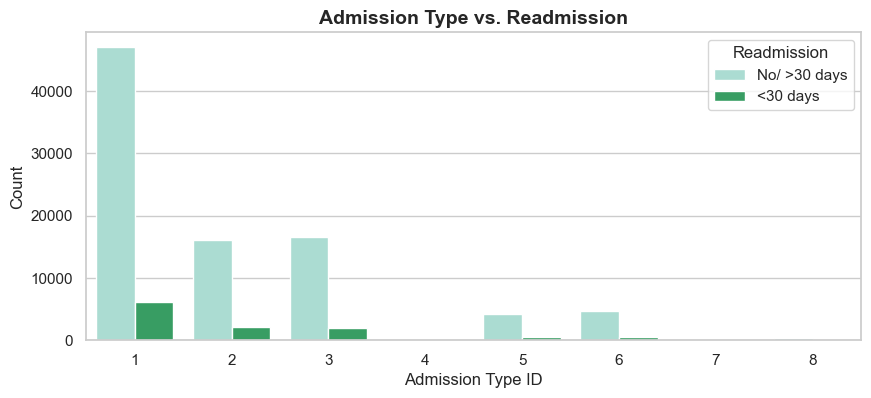

In [18]:
# Admission Type vs Readmission
plt.figure(figsize=(10, 4))
sns.countplot(x='admission_type_id', hue='readmission_binary', data=df_clean,
              palette=['#A3E4D7', '#27AE60'])
plt.title("Admission Type vs. Readmission", fontsize=14, weight='bold')
plt.xlabel("Admission Type ID")
plt.ylabel("Count")
plt.legend(title="Readmission", labels=['No/ >30 days', '<30 days'])
plt.show()


## **Feature Engineering**

In [19]:
# import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### **Risk Grouping - KMeans**

Given that the class distribution in the target variable (readmitted), where <30 is the minority class, we need to explore unsupervised risk profiling using clustering. This is because behavioral/risk clusters can reveal patient subgroups with distinct care needs. This is a very useful step before classification or for deeper clinical insights.

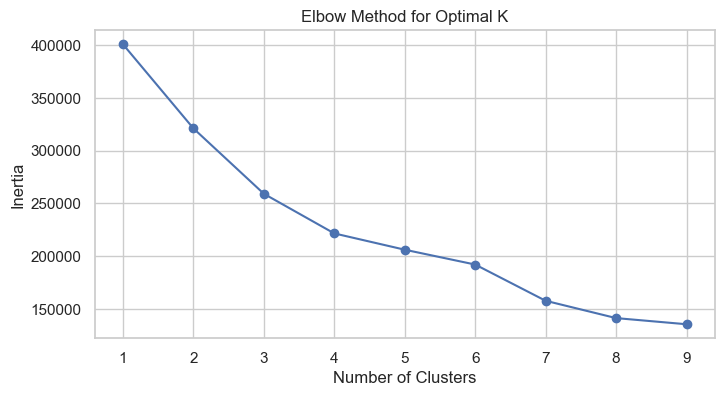

In [20]:
cluster_features = ['num_lab_procedures', 'num_medications', 'number_inpatient', 'number_emergency']
X = df_clean[cluster_features]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal cluster 
inertia = []
K = range(1, 10)

# Elbow Plot - seems like clear "elbow" at k=3, k=4, k=6 and k=7
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

Silhouette score for k=3: 0.2701
Silhouette score for k=4: 0.2659
Silhouette score for k=6: 0.2445
Silhouette score for k=7: 0.2534

Optimal number of clusters based on silhouette score: 3


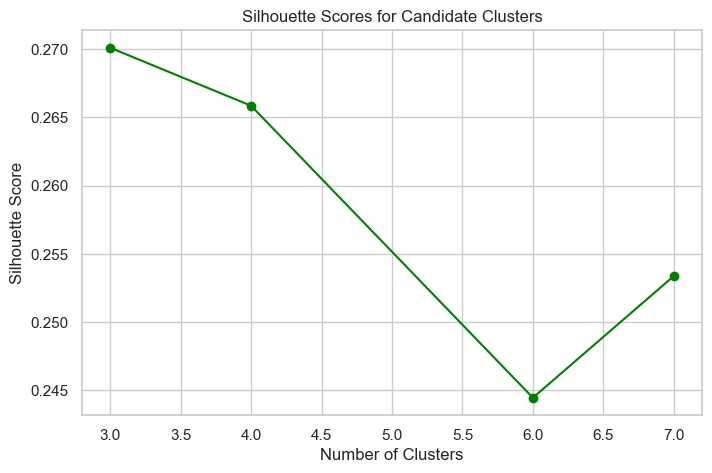

In [21]:
from sklearn.metrics import silhouette_score

# List of cluster counts to evaluate
cluster_candidates = [3, 4, 6, 7]

# Store results
silhouette_scores = {}

for k in cluster_candidates:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    labels = kmeans.labels_
    score = silhouette_score(X_scaled, labels)
    silhouette_scores[k] = score
    print(f"Silhouette score for k={k}: {score:.4f}")

# Find the best cluster count
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nOptimal number of clusters based on silhouette score: {best_k}")

plt.figure(figsize=(8, 5))
plt.plot(silhouette_scores.keys(), silhouette_scores.values(), marker='o', color='green')
plt.title("Silhouette Scores for Candidate Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [22]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['risk_cluster'] = kmeans.fit_predict(X_scaled)

   risk_cluster  early_readmit_rate
0             0            0.091839
1             1            0.244687
2             2            0.111153


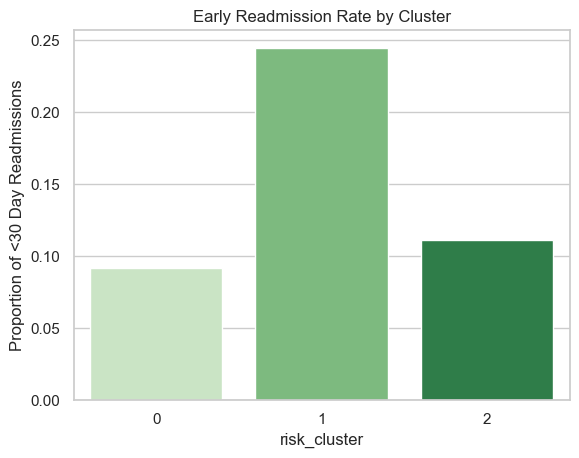

In [23]:
readmit_by_cluster = df_clean.groupby('risk_cluster')['readmission_binary'].mean().reset_index()
readmit_by_cluster.columns = ['risk_cluster', 'early_readmit_rate']

print(readmit_by_cluster)

sns.barplot(data=readmit_by_cluster, x='risk_cluster', y='early_readmit_rate', palette='Greens')
plt.title('Early Readmission Rate by Cluster')
plt.ylabel('Proportion of <30 Day Readmissions')
plt.show()

### Aggregate Drug usage columns - To analyse impact of drugs on readmission

In [24]:
# Define drug-related columns
drug_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]

# Map drug usage to numeric values
#    'No' = 0, everything else ('Steady', 'Up', 'Down') = 1
usage_map = {
    'No': 0,
    'Steady': 1,
    'Up': 1,
    'Down': 1
}

# Create a new DataFrame with numeric adherence values
df_drug_numeric = df_clean[drug_cols].replace(usage_map)

# Calculate polypharmacy score = sum of drugs being taken (1 = taken, 0 = not)
df_clean['polypharmacy_score'] = df_drug_numeric.sum(axis=1)

# Normalize score (e.g., scale 0–1 if desired)
df_clean['polypharmacy_score_norm'] = df_clean['polypharmacy_score'] / len(drug_cols)

# Inspect the result
print(df_clean[['polypharmacy_score', 'polypharmacy_score_norm']].describe())

       polypharmacy_score  polypharmacy_score_norm
count       100244.000000            100244.000000
mean             1.180629                 0.051332
std              0.921531                 0.040067
min              0.000000                 0.000000
25%              1.000000                 0.043478
50%              1.000000                 0.043478
75%              2.000000                 0.086957
max              6.000000                 0.260870


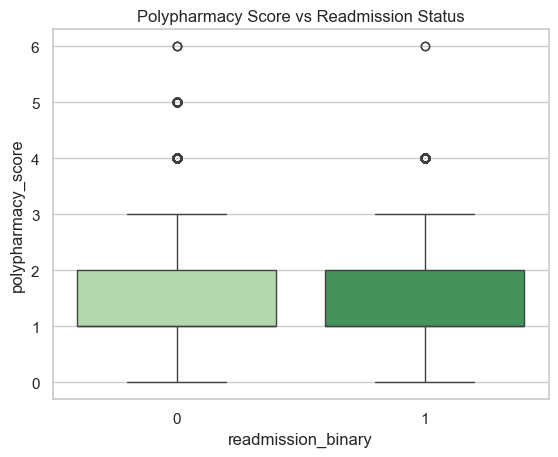

In [25]:
sns.boxplot(x='readmission_binary', y='polypharmacy_score', palette='Greens', data=df_clean)
plt.title("Polypharmacy Score vs Readmission Status")
plt.show()

Summarise final columns 

In [26]:
df_clean.shape

(100244, 48)

In [27]:
df_clean = df_clean.drop(columns=drug_cols)
df_clean.shape

(100244, 25)

## **Modelling**

In [28]:
# Encode Categorical Variable
# Identify categorical columns
cat_cols = df_clean.select_dtypes(include='object').columns.tolist()  ### This isn't all the catagorical variables, admisssion type id, discharge disposition id and admission source are also catagorical.
print("Categorical Columns:", cat_cols)

# Apply one-hot encoding
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)
print("Encoded shape:", df_encoded.shape)

Categorical Columns: ['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'change', 'diabetesMed']
Encoded shape: (100244, 2279)


In [29]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['readmission_binary'])
y = df_encoded['readmission_binary']

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (80195, 2278)
Test shape: (20049, 2278)


### 📊 Logistic Regression Summary
Logistic Regression serves as a strong baseline model due to its interpretability and speed. While performance may be limited on imbalanced data, it helps identify linear relationships between predictors and readmission risk. In this case, recall may be low due to the class imbalance, but precision helps highlight confident predictions.


In [30]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_log))

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     17799
           1       0.32      0.03      0.05      2250

    accuracy                           0.88     20049
   macro avg       0.60      0.51      0.49     20049
weighted avg       0.83      0.88      0.84     20049



### 🌲 Random Forest Summary
Random Forest performs well by leveraging multiple decision trees and reducing overfitting through ensemble learning. It tends to improve recall and F1-score on imbalanced datasets by capturing non-linear patterns. Feature importance from this model can also guide variable selection.


In [31]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🌲 Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf))


🌲 Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17799
           1       0.67      0.01      0.01      2250

    accuracy                           0.89     20049
   macro avg       0.78      0.50      0.48     20049
weighted avg       0.86      0.89      0.84     20049



### ⚡ XGBoost Summary
XGBoost outperforms traditional models in many structured-data problems due to its regularization and boosting techniques. It balances bias and variance, making it particularly useful when predicting minority classes. If tuned properly, it offers high accuracy and resilience to noise.


In [34]:
# XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17799
           1       0.50      0.03      0.06      2250

    accuracy                           0.89     20049
   macro avg       0.69      0.51      0.50     20049
weighted avg       0.85      0.89      0.84     20049



### ✅ Confusion Matrix Interpretation
The confusion matrix shows how well each model distinguishes between readmitted and non-readmitted patients. A high number of false negatives indicates missed readmissions, while high false positives suggest unnecessary flags. Optimizing the model should aim to reduce false negatives to prioritize patient safety.


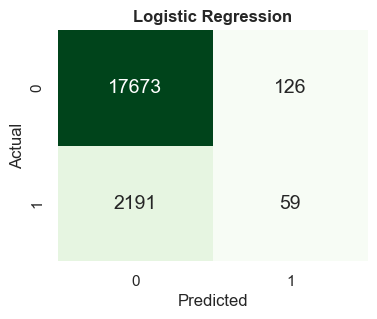

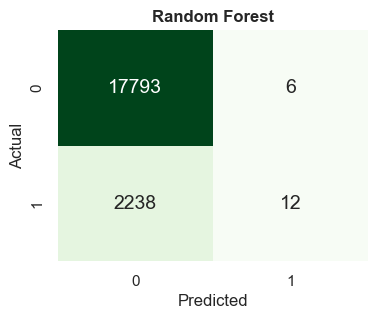

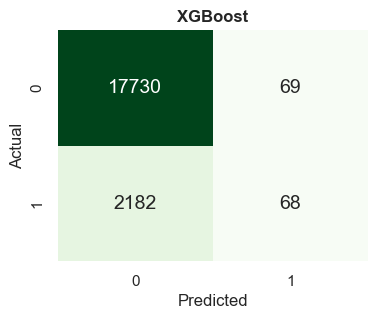

In [50]:
# Confusion Matrix Plots with Green Color Palette
from sklearn.metrics import confusion_matrix

sns.set(style="whitegrid")
green_cmap = sns.color_palette("Greens", as_cmap=True)

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap=green_cmap, cbar=False,
                annot_kws={"size": 14})
    plt.title(title, fontsize=12, weight='bold')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot for each model
plot_conf_matrix(y_test, y_pred_log, "Logistic Regression")
plot_conf_matrix(y_test, y_pred_rf, "Random Forest")
plot_conf_matrix(y_test, y_pred_xgb, "XGBoost")


In [51]:
# Adjust threshold for XGBoost
y_proba = xgb.predict_proba(X_test)[:, 1]

# Lower threshold to increase recall
y_pred_thresh = (y_proba >= 0.3).astype(int)

print("Adjusted Threshold Classification Report:")
print(classification_report(y_test, y_pred_thresh))

Adjusted Threshold Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.93     17799
           1       0.37      0.11      0.18      2250

    accuracy                           0.88     20049
   macro avg       0.63      0.55      0.55     20049
weighted avg       0.84      0.88      0.85     20049



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train_scaled, y_train)


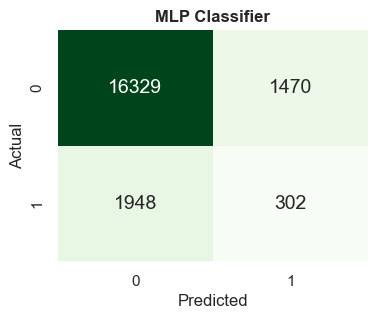

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     17799
           1       0.17      0.13      0.15      2250

    accuracy                           0.83     20049
   macro avg       0.53      0.53      0.53     20049
weighted avg       0.81      0.83      0.82     20049



In [ ]:
y_pred_mlp = mlp.predict(X_test_scaled)
y_proba_mlp = mlp.predict_proba(X_test_scaled)[:, 1]
# Confusion Matrix
plot_conf_matrix(y_test, y_pred_mlp, "MLP Classifier")

# Classification Report
print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))



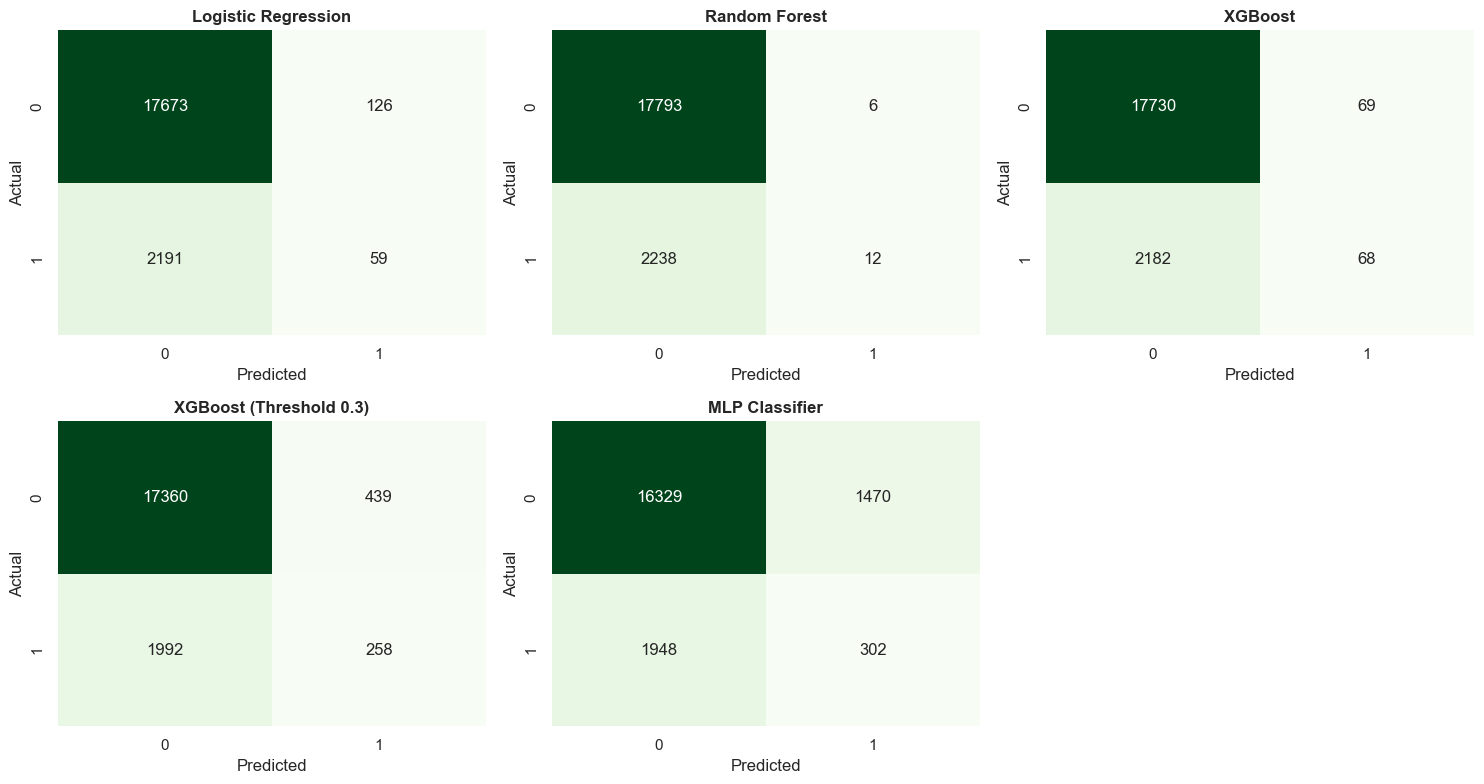

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Use a green color map
from matplotlib.cm import Greens

# Prepare model predictions and labels
model_predictions = {
    "Logistic Regression": y_pred_log,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "XGBoost (Threshold 0.3)": y_pred_thresh,
    "MLP Classifier": y_pred_mlp
}

# Set up plot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows x 3 columns
axes = axes.flatten()

# Plot each confusion matrix
for i, (title, y_pred) in enumerate(model_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=Greens, cbar=False,
                annot_kws={"size": 12}, ax=axes[i])
    axes[i].set_title(title, fontsize=12, weight='bold')
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Hide any extra subplot if total models < grid size
for j in range(len(model_predictions), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

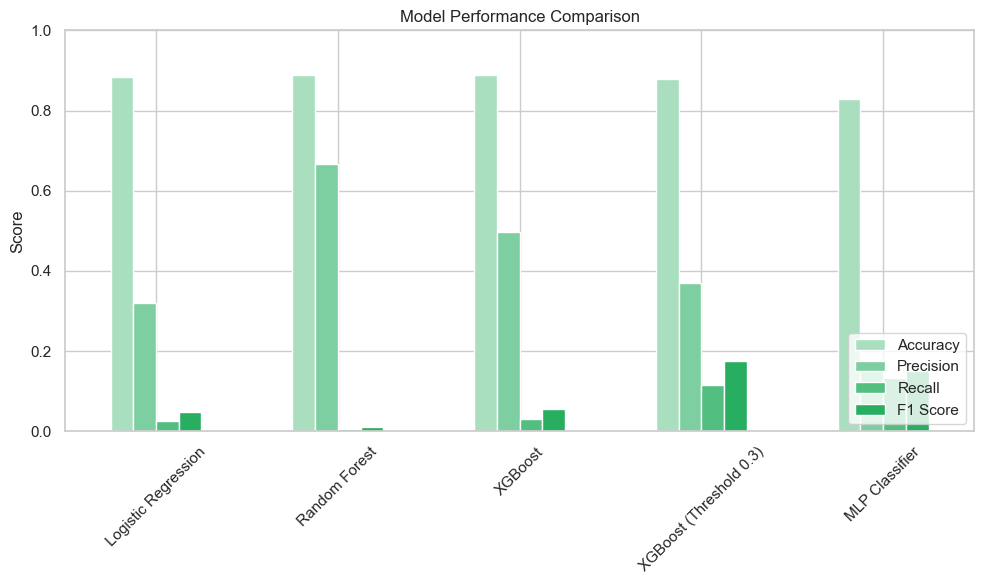

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Calculate metrics for each model
results = {}
for name, preds in model_predictions.items():
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds)
    }

# Convert to DataFrame
results_df = pd.DataFrame(results).T

green_shades = ["#A9DFBF", "#7DCEA0", "#52BE80", "#27AE60", "#1E8449"]
results_df.plot(kind='bar', figsize=(10, 6), color=green_shades)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## **Summary of Findings & Conclusion**

This project focused on predicting 30-day hospital readmissions among diabetic patients using ten years of inpatient data from 130 U.S. hospitals. The dataset included over 50 features related to patient demographics, hospital encounters, medications, and lab results. Class imbalance was a major issue, as early readmissions (<30) were underrepresented, making recall a critical performance metric.

Key feature engineering steps included aggregating 23 medication columns into a polypharmacy_score, encoding categorical variables, scaling numerics, and creating a risk_cluster variable using K-Means clustering to identify high-risk patient groups. Cluster 1 had the highest readmission rate and proved valuable for modeling.

Several models were tested: Logistic Regression, Random Forest, XGBoost, and MLP. While Random Forest and default XGBoost achieved high overall accuracy, they failed to identify many true readmissions. In contrast, XGBoost with a lowered decision threshold and the MLP model significantly improved recall by catching more actual readmissions, even at the cost of some false positives. These two models achieved the best balance between correctly identifying high-risk patients and minimizing missed cases, making them more suitable for deployment in a clinical setting.

In conclusion, combining clustering-based risk profiling with supervised classification improved the model’s predictive power. XGBoost (threshold-tuned) and MLP are the most effective for identifying early readmissions, with potential for real-world integration into hospital decision-support systems to reduce readmission rates and improve outcomes.

Future improvements could include resampling, adding more external features, and integrating the model into clinical decision-support systems.

## **Reference:**



- To ensure clarity and readability, ChatGPT (OpenAI, 2024) was used as a supportive writing tool for refining explanations, organizing content flow, and summarizing key findings. However, all critical analyses, data interpretations, and model evaluations were conducted independently, ensuring the rigor and originality of our work." OpenAI. (2024). ChatGPT (June 2024 version) [Large language model]. Retrieved from https://openai.com